In [1]:
#import all the packages

import numpy as np
import os 
import copy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import lime
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from lime import lime_tabular

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder


In [2]:
import os
for dirname, _, filenames in os.walk('/D:/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#load the dataset
# Step 1: Load and preprocess the dataset
file_path = '/Research-Semester/RP/Wind_turbine_code/wine_pipeline/data/base/Solar_categorical.csv'  # Update with the actual file path
data = pd.read_csv(file_path)

In [4]:
# Feature names and target column
features = ["S1(Amp)", "S2(Amp)", "S1(Volt)", "S2(Volt)", "Light(kiloLux)", "Temp(degC)", "Weather"]
target = 'State'

In [5]:
# Encode the categorical target variable
data.columns = data.columns.str.strip()

label_encoder = {}
for col in features:
    if data[col].dtype == 'object':  # If column is categorical
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoder[col] = le
        


In [6]:
# Split the dataset into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Step 2: Train the DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [8]:
# Step 3: Set up LIME explainer
target_encoder = LabelEncoder()
data[target] = target_encoder.fit_transform(data[target])

explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=features,
    class_names= ["Normal", "Open" , "Line-line"],
    mode='classification'
)

c:\Users\anwar\anaconda3\envs\wine_env2\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


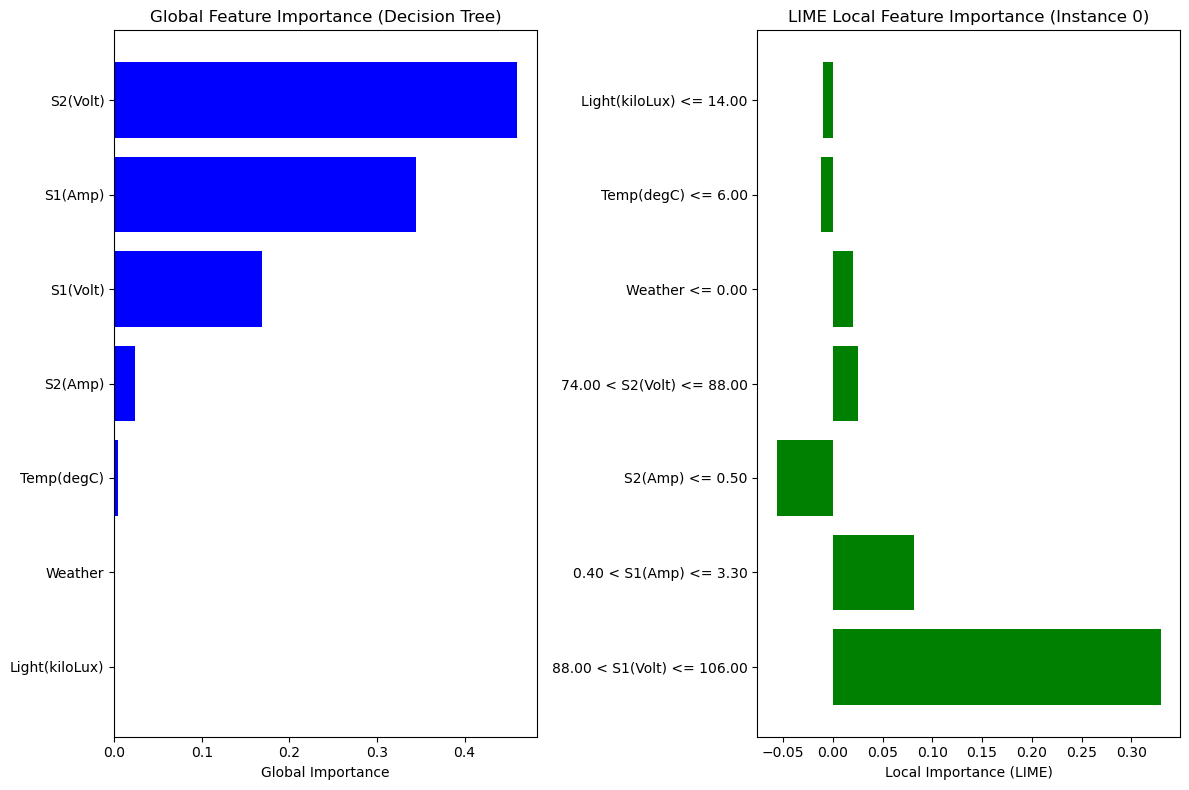

In [9]:
# Step 4: LIME feature importance (local explanation)
instance_index = 0  # Select an instance to explain
instance = X_test.iloc[instance_index].values.reshape(1, -1)

# Explain the prediction for this instance
exp = explainer.explain_instance(instance.flatten(), model.predict_proba, num_features=len(features))

# Extract LIME feature importance and corresponding feature names
lime_feature_importances = exp.as_list()
lime_feature_names, lime_importances = zip(*lime_feature_importances)

# Step 5: Global feature importance from the DecisionTreeClassifier
tree_feature_importances = model.feature_importances_

# Step 6: Plot the comparison of global and local feature importance
sorted_indices = np.argsort(tree_feature_importances)[::-1]

plt.figure(figsize=(12, 8))

# Global Feature Importance
plt.subplot(1, 2, 1)
plt.title("Global Feature Importance (Decision Tree)")
plt.barh(np.array(features)[sorted_indices], tree_feature_importances[sorted_indices], color='blue')
plt.xlabel("Global Importance")
plt.gca().invert_yaxis()

# Local Feature Importance (LIME)
plt.subplot(1, 2, 2)
plt.title(f"LIME Local Feature Importance (Instance {instance_index})")
plt.barh(lime_feature_names, lime_importances, color='green')
plt.xlabel("Local Importance (LIME)")

plt.tight_layout()
plt.show()

In [91]:
# Step 4: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.99


In [ ]:
# Define a function to calculate stability score
def calculate_stability_score(instance, model, explainer, epsilon=0.1, num_samples=20):
    # Original explanation
    exp = explainer.explain_instance(instance, model.predict_proba, num_features=len(lime_feature_names))
    phi_original = np.array([imp for _, imp in exp.as_list()])

    # Generate perturbed samples
    perturbations = np.random.normal(loc=0, scale=epsilon, size=(num_samples, instance.shape[0]))
    perturbed_samples = np.clip(instance + perturbations, X_train.values.min(axis=0), X_train.values.max(axis=0))

    max_stability = 0
    for perturbed_instance in perturbed_samples:
        # Explanation for perturbed instance
        exp_perturbed = explainer.explain_instance(perturbed_instance, model.predict_proba, num_features=len(feature_names))
        phi_perturbed = np.array([imp for _, imp in exp_perturbed.as_list()])

        # Compute L2 norms
        phi_diff = np.linalg.norm(phi_original - phi_perturbed, ord=2)
        input_diff = np.linalg.norm(instance - perturbed_instance, ord=2)

        # Stability score
        stability = phi_diff / (input_diff + 1e-8)  # Add small value to avoid division by zero
        max_stability = max(max_stability, stability)

    return max_stability

# Select a specific instance to calculate stability
instance_index = 0
instance = X_test.iloc[instance_index].values

# Calculate stability score for the instance
stability_score = calculate_stability_score(instance, model, explainer)
print(f"Stability Score for Instance wine_lime_DT {instance_index}: {stability_score}")


ValueError: could not broadcast input array from shape (7,) into shape (1,)